In [467]:
#import modules
import keras
from keras.models import Sequential
from keras.layers import *
from keras.utils import load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import metrics
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os

In [468]:
image_height = 200
image_weight = 150
sequence = 3
sequence_length = 20

def arrange_data(df, map):
    image_data = []
    ids = df[df.columns[0]]
    map = f"{map}/raw_images/"
    
    df = df.drop(df.columns[0], axis=1)
    
    for i in ids:
        img = load_img(f"{map}{i}.jpg", target_size=(image_height, image_weight, sequence))
        img = img_to_array(img)
        image_data.append(img)
    
    X = np.array(image_data)
    Y = np.array(df)
    
    print("Shape of images:", X.shape)
    print("Shape of labels:", Y.shape)
    
    return X, Y

In [469]:
# splitting data and 
current_folder = os.path.abspath('')
map = f"{current_folder}/data/"

# reads first row as header
print("Processing train..")
train_df = pd.read_csv(f"{map}train.csv", delimiter=',', header=None)
X_train, Y_train = arrange_data(train_df, current_folder)

# reads first row double
print("Processing valid..")
val_df = pd.read_csv(f"{map}valid.csv", delimiter=',', header=0)
X_val, Y_val = arrange_data(val_df, current_folder)

# scale data 
X_train = X_train / 255
X_val = X_val / 255


Processing train..
Shape of images: (614, 200, 150, 3)
Shape of labels: (614, 26)
Processing valid..
Shape of images: (236, 200, 150, 3)
Shape of labels: (236, 26)


In [470]:
# sequential model

model=Sequential()

# model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', input_shape=(image_height, image_weight, sequence)))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(image_height, image_weight, sequence)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(image_height, image_weight, sequence)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_weight, sequence)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_weight, sequence)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=512, kernel_size=(5, 5), activation='relu', input_shape=(image_height, image_weight, sequence)))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_weight, sequence)))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))



model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(26, activation='sigmoid'))

model.summary()
########################################################################################################################

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last", recurrent_dropout=0.2, input_shape=(sequence, image_height, image_weight, sequence)))
    
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
# model.add(TimeDistributed(Dropout(0.2)))

# model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh', data_format="channels_last", recurrent_dropout=0.2))

# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
# model.add(TimeDistributed(Dropout(0.2)))

# model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='tanh', data_format="channels_last", recurrent_dropout=0.2))

# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
# model.add(TimeDistributed(Dropout(0.2)))

# model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='tanh', data_format="channels_last", recurrent_dropout=0.2))

# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
# #model.add(TimeDistributed(Dropout(0.2)))

# model.add(Flatten()) 

########################################################################################################################

# model.add(Conv2D(16, (3, 3), padding='same',activation = 'relu'), input_shape=(image_height, image_weight, sequence))
    
# model.add(MaxPooling2D((4, 4)))
# model.add(Dropout(0.25))

# model.add(Conv2D(32, (3, 3), padding='same',activation = 'relu'))
# model.add(MaxPooling2D((4, 4)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same',activation = 'relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), padding='same',activation = 'relu'))
# model.add(MaxPooling2D((2, 2)))
                                    
# model.add(Flatten())
# model.add(Dropout(0.25))
                                    
# model.add(LSTM(32))

########################################################################################################################



Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_403 (Conv2D)         (None, 196, 146, 32)      2432      
                                                                 
 max_pooling2d_397 (MaxPooli  (None, 98, 73, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_404 (Conv2D)         (None, 94, 69, 64)        51264     
                                                                 
 max_pooling2d_398 (MaxPooli  (None, 47, 35, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_405 (Conv2D)         (None, 45, 33, 128)       73856     
                                                                 
 max_pooling2d_399 (MaxPooli  (None, 23, 17, 128)    

In [471]:
version = 'v11'

opt = optimizers.SGD(
    learning_rate=0.001, 
    decay=1e-5, 
    momentum=0.95, 
    nesterov=True
    )

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    mode='min',
    restore_best_weights=True
    )

model.compile(
    loss='binary_crossentropy', 
    metrics=[metrics.Precision()], 
    optimizer=opt
    # optimizer='Adam'
    # optimizer=optimizers.RMSprop(lr=1e-4)
    )

history = model.fit(X_train, Y_train, 
                    epochs=50, 
                    batch_size=64,
                    shuffle = True, 
                    # validation_split = 0.2,
                    validation_data=(X_val, Y_val), 
                    callbacks=[early_stopping_callback]
                    )

model.save(f'{current_folder}/model/generated/{version}/Model_6c_{version}.h5')

Epoch 1/50
10/10 [==============================] - 19s 2s/step - loss: 0.6876 - precision_21: 0.0710 - val_loss: 0.6755 - val_precision_21: 0.0684
Epoch 2/50
10/10 [==============================] - 18s 2s/step - loss: 0.6624 - precision_21: 0.0657 - val_loss: 0.6417 - val_precision_21: 0.0744
Epoch 3/50
10/10 [==============================] - 17s 2s/step - loss: 0.6186 - precision_21: 0.0731 - val_loss: 0.5765 - val_precision_21: 0.0686
Epoch 4/50
10/10 [==============================] - 17s 2s/step - loss: 0.5329 - precision_21: 0.0675 - val_loss: 0.4556 - val_precision_21: 0.0708
Epoch 5/50
10/10 [==============================] - 17s 2s/step - loss: 0.4079 - precision_21: 0.0860 - val_loss: 0.3373 - val_precision_21: 0.0000e+00
Epoch 6/50
10/10 [==============================] - 17s 2s/step - loss: 0.3221 - precision_21: 0.4944 - val_loss: 0.2829 - val_precision_21: 0.4444
Epoch 7/50
10/10 [==============================] - 17s 2s/step - loss: 0.2941 - precision_21: 0.4555 - val_

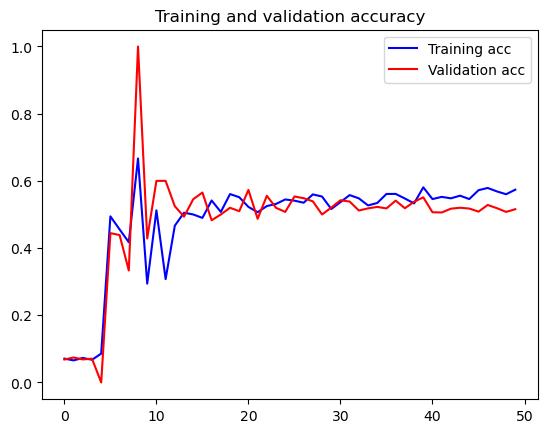

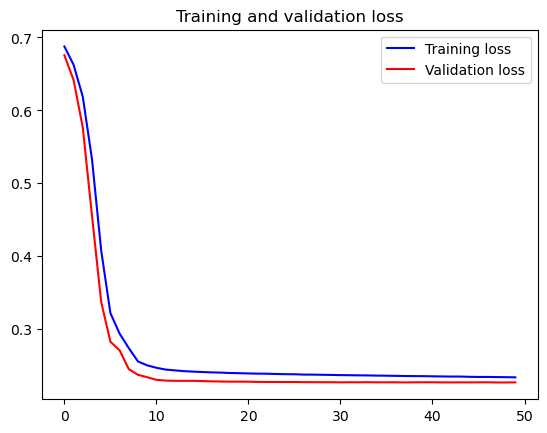

In [472]:
v = '21'
acc = history.history[f'precision_{v}']
val_acc = history.history[f'val_precision_{v}']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()